In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display 

# Read the data

In [2]:
database = '../data/database.sqlite'

In [3]:
data = sqlite3.connect(database)
tables = pd.read_sql("SELECT * FROM sqlite_master WHERE type='table'", data)

In [4]:
tables.name

0      sqlite_sequence
1    Player_Attributes
2               Player
3                Match
4               League
5              Country
6                 Team
7      Team_Attributes
Name: name, dtype: object

# Countries and Leagues

In [5]:
leagues = pd.read_sql("SELECT * FROM League JOIN Country on Country.id == League.id", data)

In [6]:
leagues

,id,country_id,name,id,name
0,1,1,Belgium Jupiler League,1,Belgium
1,1729,1729,England Premier League,1729,England
2,4769,4769,France Ligue 1,4769,France
3,7809,7809,Germany 1. Bundesliga,7809,Germany
4,10257,10257,Italy Serie A,10257,Italy
5,13274,13274,Netherlands Eredivisie,13274,Netherlands
6,15722,15722,Poland Ekstraklasa,15722,Poland
7,17642,17642,Portugal Liga ZON Sagres,17642,Portugal
8,19694,19694,Scotland Premier League,19694,Scotland
9,21518,21518,Spain LIGA BBVA,21518,Spain


# Teams

In [7]:
teams = pd.read_sql("SELECT * FROM Team", data)

In [8]:
print('number of teams:', len(teams["team_long_name"].unique()))

number of teams: 296


In [9]:
teams

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB
...,...,...,...,...,...
294,49479,10190,898.0,FC St. Gallen,GAL
295,49837,10191,1715.0,FC Thun,THU
296,50201,9777,324.0,Servette FC,SER
297,50204,7730,1862.0,FC Lausanne-Sports,LAU


# Player Attributes

In [10]:
player_attributes = pd.read_sql("SELECT * FROM Player_Attributes", data)

In [11]:
player_attributes[0:1]

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0


# Match

In [12]:
matches = pd.read_sql("SELECT * FROM Match", data)

In [13]:
# interested columns
cols = ["date", "match_api_id", "home_team_api_id", "away_team_api_id", "home_team_goal", "away_team_goal",
        "home_player_1", "home_player_2", "home_player_3", "home_player_4", "home_player_5", 
        "home_player_6", "home_player_7", "home_player_8", "home_player_9", "home_player_10", 
        "home_player_11", "away_player_1", "away_player_2", "away_player_3", "away_player_4", 
        "away_player_5", "away_player_6", "away_player_7", "away_player_8", "away_player_9", 
        "away_player_10", "away_player_11"]

matches = matches.dropna(subset=cols)[cols]

# Data Collection

## FIFA Data

In [14]:
def get_match_stat(match, player_data):
    """
    Get FIFA stats for a given match
    """
    match_date = match["date"]
    players = ["home_player_1", "home_player_2", "home_player_3", "home_player_4", "home_player_5",
               "home_player_6", "home_player_7", "home_player_8", "home_player_9", "home_player_10",
               "home_player_11", "away_player_1", "away_player_2", "away_player_3", "away_player_4",
               "away_player_5", "away_player_6", "away_player_7", "away_player_8", "away_player_9",
               "away_player_10", "away_player_11"]
    
    total_player_stat = pd.DataFrame(columns=['match_api_id'])
    
    # store match id
    total_player_stat.loc[0] = match["match_api_id"]
    
    # store each player's features
    for player in players:
        player_id = match[player]
        player_stat = player_data[player_data["player_api_id"]==player_id]
        
        # choose most recent player stat and interested features
        player_stat = player_stat[player_stat["date"] < match_date][0:1]
        player_stat = player_stat[player_stat.columns[4:]]
        
        # rename keys
        new_keys = []
        for key in player_stat.columns:
            key_name = "{}_{}".format(player, key)
            new_keys.append(key_name)
        player_stat.columns = new_keys
        player_stat.reset_index(inplace=True, drop=True)
        
        # concate data
        total_player_stat = pd.concat([total_player_stat, player_stat], axis=1)
        
    return total_player_stat.loc[0]

        
def get_FIFA(match_data, player_data, path="", load_data=False):
    """
    Get FIFA data for all matches
    """
    if load_data:
        fifa_data = pd.read_pickle(path + "fifa_data.pkl")
    else:
        print("Collecting FIFA data...")
        fifa_data = match_data.apply(lambda x: get_match_stat(x, player_data), axis=1)
        print("Finish")

        #Save data as pickle
        fifa_data.to_pickle("fifa_data.pkl", protocol=2)
    return fifa_data

In [15]:
fifa_data = get_FIFA(matches, player_attributes, load_data=True)

In [16]:
fifa_data

,match_api_id,home_player_1_overall_rating,home_player_1_potential,home_player_1_preferred_foot,home_player_1_attacking_work_rate,home_player_1_defensive_work_rate,home_player_1_crossing,home_player_1_finishing,home_player_1_heading_accuracy,home_player_1_short_passing,...,away_player_11_vision,away_player_11_penalties,away_player_11_marking,away_player_11_standing_tackle,away_player_11_sliding_tackle,away_player_11_gk_diving,away_player_11_gk_handling,away_player_11_gk_kicking,away_player_11_gk_positioning,away_player_11_gk_reflexes
145,493017,58.0,67.0,right,medium,medium,25.0,25.0,25.0,25.0,...,61.0,54.0,23.0,34.0,22.0,13.0,23.0,45.0,23.0,23.0
153,493025,64.0,67.0,right,medium,medium,20.0,20.0,20.0,56.0,...,46.0,66.0,21.0,29.0,24.0,1.0,23.0,45.0,23.0,23.0
155,493027,67.0,69.0,right,medium,medium,29.0,36.0,25.0,52.0,...,67.0,56.0,40.0,35.0,37.0,1.0,23.0,62.0,23.0,23.0
162,493034,58.0,67.0,right,medium,medium,25.0,25.0,25.0,25.0,...,73.0,65.0,27.0,38.0,31.0,3.0,23.0,54.0,23.0,23.0
168,493040,61.0,65.0,right,medium,medium,23.0,23.0,34.0,35.0,...,58.0,59.0,21.0,24.0,27.0,12.0,23.0,46.0,23.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25972,1992089,61.0,71.0,right,medium,medium,25.0,25.0,25.0,36.0,...,69.0,58.0,49.0,54.0,39.0,6.0,10.0,8.0,9.0,12.0
25974,1992091,62.0,62.0,right,medium,medium,11.0,15.0,15.0,29.0,...,69.0,58.0,49.0,54.0,39.0,6.0,10.0,8.0,9.0,12.0
25975,1992092,62.0,62.0,right,medium,medium,13.0,12.0,22.0,25.0,...,66.0,69.0,33.0,31.0,25.0,9.0,7.0,12.0,12.0,7.0
25976,1992093,65.0,71.0,right,medium,medium,17.0,19.0,18.0,27.0,...,56.0,72.0,15.0,17.0,15.0,6.0,9.0,9.0,10.0,10.0


## Label

In [55]:
def get_label_from_match(match):
    """
    Get label from a given match
    """
    label = pd.DataFrame()
    label.loc[0, "match_api_id"] = match["match_api_id"]
    home_goal = match["home_team_goal"]
    away_goal = match["away_team_goal"]

    if home_goal > away_goal:
        label.loc[0, "label"] = "win"
    elif home_goal < away_goal:
        label.loc[0, "label"] = "loss"
    else:
        label.loc[0, "label"] = "tie"
    return label.loc[0]

In [56]:
labels = matches.apply(get_label_from_match, axis=1)

In [57]:
labels

,match_api_id,label
145,493017.0,win
153,493025.0,loss
155,493027.0,win
162,493034.0,win
168,493040.0,tie
...,...,...
25972,1992089.0,tie
25974,1992091.0,win
25975,1992092.0,loss
25976,1992093.0,win


21518    3040
4769     3040
1729     3040
10257    3017
13274    2448
7809     2448
17642    2052
15722    1920
19694    1824
1        1728
24558    1422
Name: league_id, dtype: int64


([<matplotlib.patches.Wedge at 0x119483210>,
 [Text(1.1198217289384271, 0.4312763561770481, ''),
  Text(0.541249360735116, 1.0710037952798435, ''),
  Text(-0.31696745116541414, 1.1573813696883586, ''),
  Text(-1.0096183168443726, 0.6485914386517417, ''),
  Text(-1.1951594903051257, -0.10767447577579596, ''),
  Text(-0.8540046889830342, -0.693308006008146, ''),
  Text(-0.3717117732385015, -1.0352924019985315, ''),
  Text(0.14872604795924152, -1.0898993360207287, ''),
  Text(0.610511826557339, -0.9150274911900853, ''),
  Text(0.9361151198287325, -0.5776577554469756, ''),
  Text(1.0837764166005588, -0.18822507489825094, '')],
 [Text(0.6532293418807491, 0.2515778744366114, '11.7%'),
  Text(0.3157287937621509, 0.6247522139132419, '11.7%'),
  Text(-0.18489767984649158, 0.6751391323182091, '11.7%'),
  Text(-0.5889440181592174, 0.3783450058801826, '11.6%'),
  Text(-0.6971763693446565, -0.0628101108692143, '9.4%'),
  Text(-0.4658207394452913, -0.3781680032771705, '9.4%'),
  Text(-0.202751876311

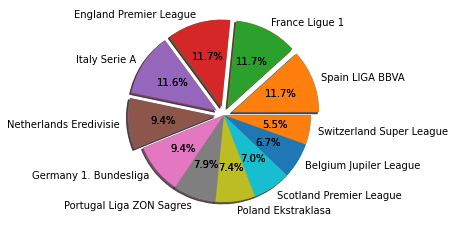

In [19]:
df_match = pd.read_sql("SELECT * FROM Match", data)
pie_match=df_match['league_id'].value_counts()#ndarray
dict_pie_match=dict(pie_match)
print(pie_match)
df_league_name=pd.read_sql("SELECT id,name FROM League", data)
list_label=["Spain LIGA BBVA","France Ligue 1","England Premier League",\
            "Italy Serie A","Netherlands Eredivisie","Germany 1. Bundesliga",\
            "Portugal Liga ZON Sagres","Poland Ekstraklasa",\
            "Scotland Premier League","Belgium Jupiler League",\
            "Switzerland Super League"]
plt.pie(pie_match,labels=list_label,shadow=True,\
        explode=(0.1,0.1,0.1,0.1,0.1,0,0,0,0,0,0),autopct="%1.1F%%")
plt.pie(pie_match,shadow=True,\
        explode=(0.1,0.1,0.1,0.1,0.1,0,0,0,0,0,0),autopct="%1.1F%%")